In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torchvision import transforms

In [2]:
trainset = torchvision.datasets.MNIST('./data',transform=transforms.ToTensor(),download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 112835818.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39189807.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28071272.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5753708.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True,num_workers=4)

In [4]:
class VAE(nn.Module):

    def __init__(self, image_size = 28*28, hidden_dim = 128, latent_dim = 64):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size,hidden_dim),
            nn.ReLU()
        )

        self.fc2 = nn.Linear(hidden_dim,latent_dim)
        self.fc3 = nn.Linear(hidden_dim,latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,image_size)
#             nn.Sigmoid()
        )

    def encode(self,x):
        tmp = self.encoder(x)
        mu, logsigma = self.fc2(tmp), self.fc3(tmp)
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        sigma = torch.exp(logsigma/2)
        epsilion = torch.normal(mean=0.0,
                                std=torch.ones_like(sigma),
                                out=torch.Tensor(sigma.size()).cuda())
        return mu + epsilion * sigma

    def decode(self,x):
        tmp = self.decoder(x)
        return tmp

    def latents(self, x):
        x = x.view(-1,784)
        mu, logsigma = self.encode(x)
        tmp = self.reparameterize(mu,logsigma)
        return tmp
    def forward(self,x):
        x = x.view(-1,784)
        mu, logsigma = self.encode(x)
        tmp = self.reparameterize(mu,logsigma)
        tmp = self.decode(tmp)

        return tmp, mu, logsigma

In [5]:
class customloss(nn.Module):

    def __init__(self, kld_weight=1):
        super(customloss,self).__init__()
        self.kld_weight = kld_weight

    def forward(self,x, img_flatten, mu,logsigma):
        reconstruct_loss = F.mse_loss(output, img_flatten,reduction='sum')
#         reconstruct_loss = F.binary_cross_entropy(output, img_flatten,reduction='sum')
        KLD = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
        loss = reconstruct_loss+ self.kld_weight * KLD

        return loss

In [6]:
model = VAE(hidden_dim=256,latent_dim=64).cuda()

In [7]:
criterion = customloss(kld_weight=1)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [8]:
epoches = 50

In [9]:
training_loss = []

model.train()
for epoch in range(epoches):
    for data in tqdm(trainloader):

        img, label = data
        img = img.cuda()

        img_flatten = img.view(-1,784)

        output, mu, logsigma = model(img)

        optimizer.zero_grad()
        loss = criterion(output, img_flatten, mu, logsigma)
        loss.backward()
        optimizer.step()

        img = img.detach().cpu()

    print(f'epoch {epoch+1}: {loss/len(trainset)}')
    current_loss = loss.detach().cpu().item() / len(trainset)
    training_loss.append(current_loss)

100%|██████████| 1875/1875 [00:09<00:00, 195.83it/s]


epoch 1: 0.025675399228930473


100%|██████████| 1875/1875 [00:08<00:00, 231.49it/s]


epoch 2: 0.021491803228855133


100%|██████████| 1875/1875 [00:08<00:00, 230.62it/s]


epoch 3: 0.022385910153388977


100%|██████████| 1875/1875 [00:08<00:00, 225.81it/s]


epoch 4: 0.020943041890859604


100%|██████████| 1875/1875 [00:08<00:00, 219.49it/s]


epoch 5: 0.020470410585403442


100%|██████████| 1875/1875 [00:08<00:00, 229.59it/s]


epoch 6: 0.019783098250627518


100%|██████████| 1875/1875 [00:08<00:00, 224.30it/s]


epoch 7: 0.01964910514652729


100%|██████████| 1875/1875 [00:08<00:00, 228.81it/s]


epoch 8: 0.019801974296569824


100%|██████████| 1875/1875 [00:08<00:00, 224.26it/s]


epoch 9: 0.019214889034628868


100%|██████████| 1875/1875 [00:08<00:00, 222.94it/s]


epoch 10: 0.01877150870859623


100%|██████████| 1875/1875 [00:08<00:00, 224.96it/s]


epoch 11: 0.0189225934445858


100%|██████████| 1875/1875 [00:08<00:00, 224.05it/s]


epoch 12: 0.018837211653590202


100%|██████████| 1875/1875 [00:08<00:00, 227.91it/s]


epoch 13: 0.018328068777918816


100%|██████████| 1875/1875 [00:08<00:00, 228.31it/s]


epoch 14: 0.017203116789460182


100%|██████████| 1875/1875 [00:08<00:00, 224.58it/s]


epoch 15: 0.016568228602409363


100%|██████████| 1875/1875 [00:08<00:00, 221.22it/s]


epoch 16: 0.017659306526184082


100%|██████████| 1875/1875 [00:08<00:00, 228.50it/s]


epoch 17: 0.019104061648249626


100%|██████████| 1875/1875 [00:08<00:00, 225.43it/s]


epoch 18: 0.019291190430521965


100%|██████████| 1875/1875 [00:08<00:00, 223.59it/s]


epoch 19: 0.017240284010767937


100%|██████████| 1875/1875 [00:08<00:00, 226.39it/s]


epoch 20: 0.01688556559383869


100%|██████████| 1875/1875 [00:08<00:00, 227.47it/s]


epoch 21: 0.02010689675807953


100%|██████████| 1875/1875 [00:08<00:00, 223.04it/s]


epoch 22: 0.016706081107258797


100%|██████████| 1875/1875 [00:08<00:00, 225.12it/s]


epoch 23: 0.01673745922744274


100%|██████████| 1875/1875 [00:08<00:00, 225.72it/s]


epoch 24: 0.018930695950984955


100%|██████████| 1875/1875 [00:08<00:00, 225.82it/s]


epoch 25: 0.018775466829538345


100%|██████████| 1875/1875 [00:08<00:00, 223.04it/s]


epoch 26: 0.017827600240707397


100%|██████████| 1875/1875 [00:08<00:00, 223.87it/s]


epoch 27: 0.018448950722813606


100%|██████████| 1875/1875 [00:08<00:00, 226.87it/s]


epoch 28: 0.01587163843214512


100%|██████████| 1875/1875 [00:08<00:00, 225.11it/s]


epoch 29: 0.018669117242097855


100%|██████████| 1875/1875 [00:08<00:00, 219.55it/s]


epoch 30: 0.015682509168982506


100%|██████████| 1875/1875 [00:08<00:00, 219.44it/s]


epoch 31: 0.01725485920906067


100%|██████████| 1875/1875 [00:08<00:00, 225.00it/s]


epoch 32: 0.01569630578160286


100%|██████████| 1875/1875 [00:08<00:00, 226.75it/s]


epoch 33: 0.016569936648011208


100%|██████████| 1875/1875 [00:08<00:00, 222.38it/s]


epoch 34: 0.01729048602283001


100%|██████████| 1875/1875 [00:08<00:00, 229.54it/s]


epoch 35: 0.01841464824974537


100%|██████████| 1875/1875 [00:08<00:00, 226.11it/s]


epoch 36: 0.016279537230730057


100%|██████████| 1875/1875 [00:08<00:00, 223.42it/s]


epoch 37: 0.01751268282532692


100%|██████████| 1875/1875 [00:08<00:00, 219.48it/s]


epoch 38: 0.018073055893182755


100%|██████████| 1875/1875 [00:08<00:00, 216.84it/s]


epoch 39: 0.01692591980099678


100%|██████████| 1875/1875 [00:08<00:00, 220.48it/s]


epoch 40: 0.017921265214681625


100%|██████████| 1875/1875 [00:08<00:00, 219.93it/s]


epoch 41: 0.01838020794093609


100%|██████████| 1875/1875 [00:08<00:00, 215.64it/s]


epoch 42: 0.016060004010796547


100%|██████████| 1875/1875 [00:08<00:00, 220.77it/s]


epoch 43: 0.01603066362440586


100%|██████████| 1875/1875 [00:08<00:00, 220.70it/s]


epoch 44: 0.016628390178084373


100%|██████████| 1875/1875 [00:08<00:00, 218.66it/s]


epoch 45: 0.01664705201983452


100%|██████████| 1875/1875 [00:09<00:00, 199.72it/s]


epoch 46: 0.015496497042477131


100%|██████████| 1875/1875 [00:09<00:00, 200.90it/s]


epoch 47: 0.016924617812037468


100%|██████████| 1875/1875 [00:09<00:00, 197.80it/s]


epoch 48: 0.017157163470983505


100%|██████████| 1875/1875 [00:08<00:00, 220.46it/s]


epoch 49: 0.017146751284599304


100%|██████████| 1875/1875 [00:08<00:00, 213.38it/s]

epoch 50: 0.01682991161942482


In [10]:
for i in training_loss:
  print(i)

0.025675398763020833
0.021491802978515624
0.022385909016927084
0.0209430419921875
0.02047041015625
0.019783097330729166
0.019649104817708332
0.019801973470052085
0.019214888509114583
0.0187715087890625
0.01892259318033854
0.018837211100260418
0.018328068033854165
0.017203116861979166
0.016568229166666667
0.017659305826822916
0.019104060872395832
0.019291190592447917
0.017240283203125
0.016885565185546875
0.02010689697265625
0.016706081136067707
0.01673745829264323
0.018930696614583332
0.018775465901692708
0.01782760009765625
0.0184489501953125
0.015871637980143228
0.0186691162109375
0.015682509358723958
0.0172548583984375
0.015696305338541668
0.016569937133789063
0.017290486653645833
0.0184146484375
0.016279536946614583
0.01751268310546875
0.018073055013020832
0.016925919596354165
0.0179212646484375
0.01838020833333333
0.016060003662109374
0.016030663045247397
0.016628390502929687
0.016647052001953124
0.01549649658203125
0.016924617513020834
0.01715716349283854
0.01714675089518229
0.01

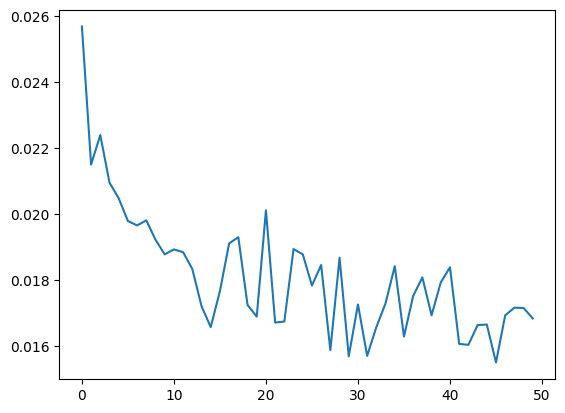

In [11]:
plt.plot(training_loss)

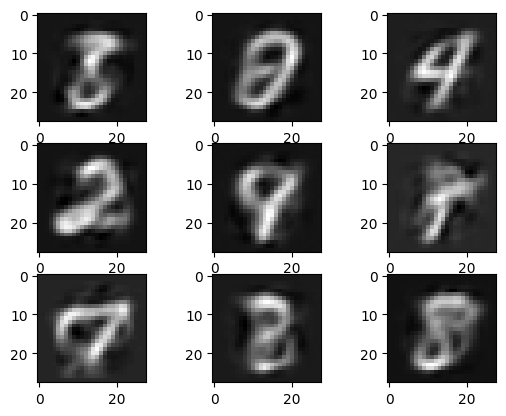

In [12]:
for i in range(3):
    for j in range(3):
        model.eval()
        with torch.no_grad():
            seeds = np.random.normal(0,1,(1,64))
            seeds = torch.from_numpy(seeds).float().cuda()

            output = model.decode(seeds)
            output = output.view(28,28)

            plt.subplot(3,3,i*3+j+1)
            plt.imshow(output.detach().cpu().numpy(),cmap='gray')

4


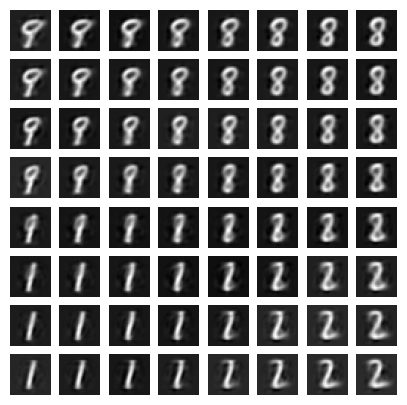

In [13]:
images = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(images, batch_size=4)
latent_dim = 64

def interpolate(latent_1, latent_2, num_steps):
   return [(1 - alpha) * latent_1 + alpha * latent_2 for alpha in np.linspace(0, 1, num_steps)]
# Sample four random images
model.cuda()
random_indices = torch.randint(len(trainloader.dataset), size=(4,))
sample_images = [trainloader.dataset[i][0] for i in random_indices]

sample_latents = [model.latents(img.cuda().view(-1, 784)).detach() for img in sample_images]


interpolated_latents = []
print(len(sample_latents))
sample_latents.append(sample_latents[0])
#4 corner
# Interpolate horizontally (top and bottom rows of the grid)
top_row = interpolate(sample_latents[0], sample_latents[1], 8)
bottom_row = interpolate(sample_latents[2], sample_latents[3], 8)

# Interpolate vertically (left and right columns of the grid)
left_col = interpolate(sample_latents[0], sample_latents[2], 8)
right_col = interpolate(sample_latents[1], sample_latents[3], 8)

interpolated_images = [[None for _ in range(8)] for _ in range(8)]

# Fill the corners
interpolated_images[0][0] = model.decoder(sample_latents[0]).cpu().view(28, 28)
interpolated_images[0][7] = model.decoder(sample_latents[1]).cpu().view(28, 28)
interpolated_images[7][0] = model.decoder(sample_latents[2]).cpu().view(28, 28)
interpolated_images[7][7] = model.decoder(sample_latents[3]).cpu().view(28, 28)

# Fill top and bottom rows
for i in range(1, 7):
    interpolated_images[0][i] = model.decoder(top_row[i]).cpu().view(28, 28)
    interpolated_images[7][i] = model.decoder(bottom_row[i]).cpu().view(28, 28)

# Fill left and right columns
for i in range(1, 7):
    interpolated_images[i][0] = model.decoder(left_col[i]).cpu().view(28, 28)
    interpolated_images[i][7] = model.decoder(right_col[i]).cpu().view(28, 28)

# Fill the rest of the grid by interpolating between corresponding points in the left and right columns
for i in range(1, 7):
    row_interpolation = interpolate(left_col[i], right_col[i], 8)
    for j in range(1, 7):
        interpolated_images[i][j] = model.decoder(row_interpolation[j]).cpu().view(28, 28)
# Plot the grid
fig, axes = plt.subplots(8, 8, figsize=(5, 5))
for i in range(8):
    for j in range(8):
        ax = axes[i][j]
        ax.imshow(interpolated_images[i][j].detach().numpy(), cmap='gray')
        ax.axis('off')
# for i in range(len(sample_latents) ):
#     for j in range(i+1, len(sample_latents)):
#         interpolated_latents.extend(interpolate(sample_latents[i], sample_latents[j], 8))

# interpolated_images = [model.decoder(latent).cpu().view(28, 28) for latent in interpolated_latents]
# fig, axes = plt.subplots(8, 8, figsize=(8, 8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(interpolated_images[i].detach().numpy(), cmap='gray')
#     ax.axis('off')
plt.show()


In [14]:
torch.save(model.state_dict(),'vae.pth')